In [1]:
import os
import glob
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import astropy.io.fits as fits

import pyklip.spectra_management as specmanage
import pyklip.fm as fm
import pyklip.instruments.GPI as GPI
import pyklip.fitpsf as fitpsf
import pyklip.fmlib.fmpsf as fmpsf


# Generate the Forward Model

## Generate the instrumental PSF for GPI Data

We will use the satellite spots to generate the instrumental PSF of the data. The output will be a 37x25x25 spectral cube, with each wavelength containing a 25x25 pixel stamp of the instrumental PSF. We will normalize the instrumental PSF to unity

In [2]:
# Read the files first

# grab the files
filelist = glob.glob(os.path.join("..", "tests", "data", "S20131210*distorcorr.fits"))
filelist.sort()
# hopefully there is still 3 filelists
assert(len(filelist) == 3)

# read in data, with a not very aggressive high pass filter just to remove low frequency background
dataset = GPI.GPIData(filelist, highpass=40)

Reading File: ..\tests\data\S20131210S0092_spdc_distorcorr.fits
Reading File: ..\tests\data\S20131210S0099_spdc_distorcorr.fits
Reading File: ..\tests\data\S20131210S0111_spdc_distorcorr.fits


C:\Users\jwang\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


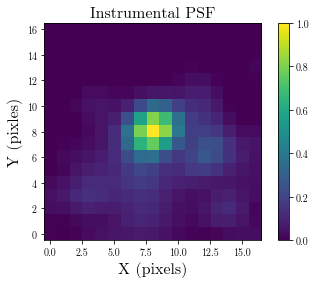

In [3]:
# generate PSF
cubesize=17
dataset.generate_psfs(boxrad=cubesize//2)
dataset.psfs /= (np.mean(dataset.spot_flux.reshape([dataset.spot_flux.shape[0] / 37, 37]), axis=0)[:, None, None])

# Let's plot the instrumental PSF, collapsed in the wavelength dimension
collapsed_psf = np.mean(dataset.psfs, axis=0)

fig = plt.figure()

plt.imshow(collapsed_psf, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
plt.gca().invert_yaxis()
plt.xlabel("X (pixels)", fontsize=16)
plt.ylabel("Y (pixles)", fontsize=16)
plt.colorbar()
plt.title("Instrumental PSF", fontsize=16)


## Initial Estimates of the Position and Spectrum of the Planet

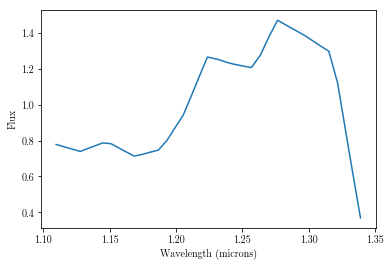

In [4]:
# setup FM guesses
numbasis = np.array([1, 7, 100]) # KL basis cutoffs you want to try
guesssep = 30.1 # estimate of separation in pixels
guesspa = 212.2 # estimate of position angle, in degrees
guessflux = 5e-5 # estimated contrast
dn_per_contrast = dataset.dn_per_contrast # DN/contrast ratio. For GPI, this is dataset.dn_per_contrast

# Let's grab the 1600 K, g=100, no cloud model from the pyklip spectral library
spectra_folder = os.path.dirname(os.path.abspath(specmanage.__file__)) + os.sep + "spectra" + os.sep
spectra_file = spectra_folder + os.sep + "g100ncflx" + os.sep + "t1600g100nc.flx"
# we want each spectra to only have 37 channels (we don't need it to repeat for each file)
unique_wvs = np.unique(dataset.wvs)
guessspec = specmanage.get_planet_spectrum(spectra_file, unique_wvs)[1]

# plot the spectrum
plt.plot(unique_wvs, guessspec)
plt.xlabel("Wavelength (microns)")
plt.ylabel("Flux")

## Initialize the fmpsf class

This provides the functionality to forward model a planet PSF through KLIP. The warning about the coefficients of the spline that appears when running the following line of code can be safely ignored 

In [5]:
fm_class = fmpsf.FMPlanetPSF(dataset.input.shape, numbasis, guesssep, guesspa, guessflux, dataset.psfs,
                                 np.unique(dataset.wvs), dn_per_contrast, star_spt='A6',
                                 spectrallib=[guessspec])

C:\Users\jwang\Anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:1112: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=111). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  warnings.warn(message)


In [6]:
# PSF subtraction parameters
# You should change these to be suited to your data!
outputdir = "." # where to write the output files
prefix = "betpic-131210-j-fmpsf" # fileprefix for the output files
annulus_bounds = [[guesssep-15, guesssep+15]] # one annulus centered on the planet
subsections = 1 # we are not breaking up the annulus
padding = 0 # we are not padding our zones
movement = 4 # we are using an conservative exclusion criteria of 4 pixels


# run KLIP-FM
fm.klip_dataset(dataset, fm_class, outputdir=outputdir, fileprefix=prefix, numbasis=numbasis,
                annuli=annulus_bounds, subsections=subsections, padding=padding, movement=movement)



Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time
 100.00% of sector, 100.00% of total completed
Closing threadpool
Writing KLIPed Images to directory C:\Users\jwang\OneDrive\GPI\klip\pyklip\examples


C:\Users\jwang\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
C:\Users\jwang\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


# Fitting the Forward Model to the Data

## Read in output of the KLIP-FM back in

In [7]:
# read in outputs
output_prefix = os.path.join(outputdir, prefix)
fm_hdu = fits.open(output_prefix + "-fmpsf-KLmodes-all.fits")
data_hdu = fits.open(output_prefix + "-klipped-KLmodes-all.fits")

# get FM frame, use KL=7
fm_frame = fm_hdu[1].data[1]
fm_centx = fm_hdu[1].header['PSFCENTX']
fm_centy = fm_hdu[1].header['PSFCENTY']

# get data_stamp frame, use KL=7
data_frame = data_hdu[1].data[1]
data_centx = data_hdu[1].header["PSFCENTX"]
data_centy = data_hdu[1].header["PSFCENTY"]

# get initial guesses
guesssep = fm_hdu[0].header['FM_SEP']
guesspa = fm_hdu[0].header['FM_PA']

## Initialize the FM Astrometry Class
This class runs the fitting with MCMC and Gaussian processes. We need to set it up. We will feed it the data, set up the Gaussian process kernel, and set the bounds for the prior distribution (we are assuming flat priors)

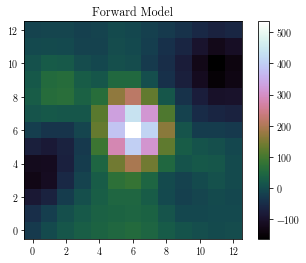

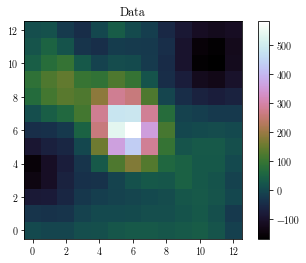

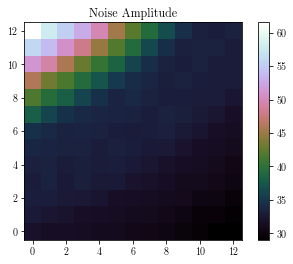

In [8]:
import pyklip.fitpsf as fitpsf
# create FM Astrometry object
fma = fitpsf.FMAstrometry(guesssep, guesspa, 13)

# generate FM stamp
# padding should be greater than 0 so we don't run into interpolation problems
padding = 5
fma.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=padding)

# plot the FM, remove the padding
fig = plt.figure()
plt.imshow(fma.fm_stamp[padding:-padding, padding:-padding], interpolation='nearest', cmap='cubehelix')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Forward Model")

# generate data_stamp stamp
# not that dr=4 means we are using a 4 pixel wide annulus to sample the noise for each pixel
# exclusion_radius excludes all pixels less than that distance from the estimated location of the planet
fma.generate_data_stamp(data_frame, [data_centx, data_centy], dr=4, exclusion_radius=10)

# plot the data
fig = plt.figure()
plt.imshow(fma.data_stamp, interpolation='nearest', cmap='cubehelix')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Data")

# we also generate the noise map here so let's plot that
fig = plt.figure()
plt.imshow(fma.noise_map, interpolation='nearest', cmap='cubehelix')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Noise Amplitude")

In [9]:
# set kernel
# we will use a Matern (\nu=3/2) kernel with no read noise term
corr_len_guess = 3.
corr_len_label = r"$l$"
fma.set_kernel("matern32", [corr_len_guess], [corr_len_label])

In [10]:
# set bounds
x_range = 1.5 # pixels
y_range = 1.5 # pixels
flux_range = 1. # flux can vary by an order of magnitude
corr_len_range = 1. # between 0.3 and 30
fma.set_bounds(x_range, y_range, flux_range, [corr_len_range])

## Finally, run the MCMC fit
You should adjust the number of burn in steps, the number of production steps, and the number of threads as appropriate for your problem.

We are also going to pickle the chains and save them for future reference

In [11]:
# run MCMC fit
fma.fit_astrometry(nwalkers=100, nburn=200, nsteps=300, numthreads=1, chain_output="betpic-131210-j-astrometry.pkl")

Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished


# Plotting the Results

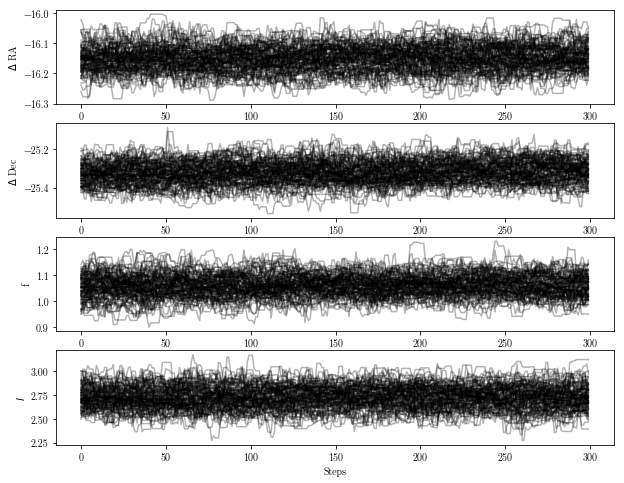

In [12]:
fig = plt.figure(figsize=(10,8))

# grab the chains from the sampler
chain = fma.sampler.chain

# plot RA offset
ax1 = fig.add_subplot(411)
ax1.plot(chain[:,:,0].T, '-', color='k', alpha=0.3)
ax1.set_xlabel("Steps")
ax1.set_ylabel(r"$\Delta$ RA")

# plot Dec offset
ax2 = fig.add_subplot(412)
ax2.plot(chain[:,:,1].T, '-', color='k', alpha=0.3)
ax2.set_xlabel("Steps")
ax2.set_ylabel(r"$\Delta$ Dec")

# plot flux scaling
ax3 = fig.add_subplot(413)
ax3.plot(chain[:,:,2].T, '-', color='k', alpha=0.3)
ax3.set_xlabel("Steps")
ax3.set_ylabel("f")

# plot hyperparameters.. we only have one for this example: the correlation length
ax4 = fig.add_subplot(414)
ax4.plot(chain[:,:,3].T, '-', color='k', alpha=0.3)
ax4.set_xlabel("Steps")
ax4.set_ylabel(r"$l$")

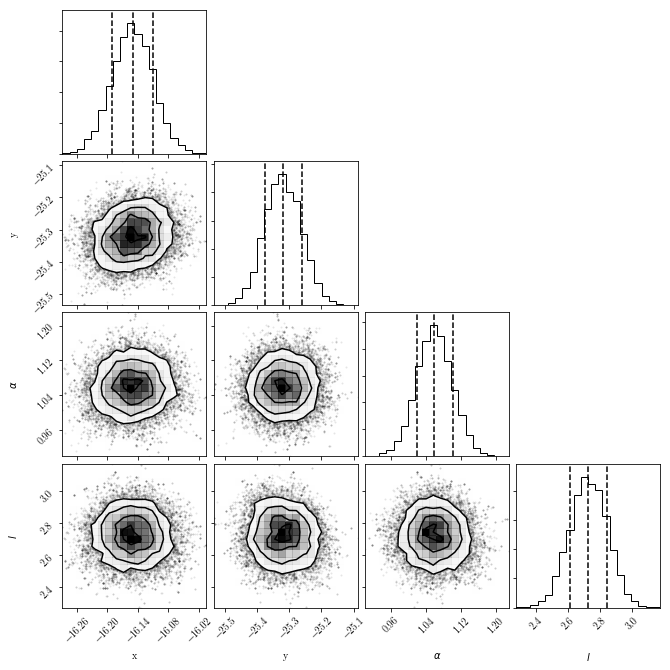

In [13]:
fig = fma.make_corner_plot()

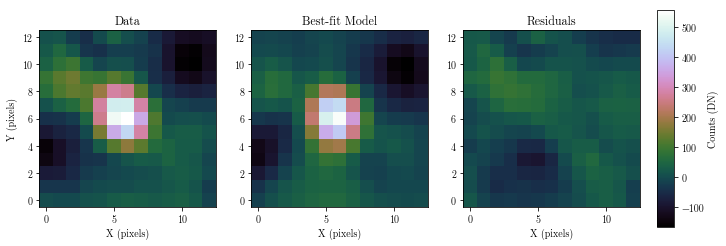

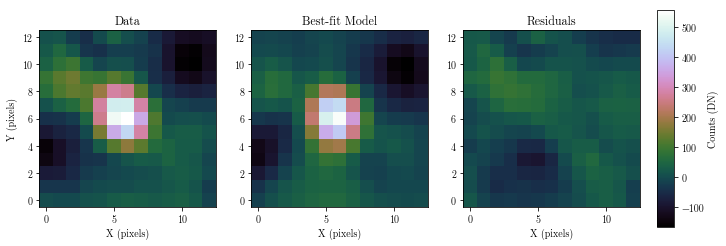

In [15]:

fma.best_fit_and_residuals()

In [17]:
fma.propogate_errs(star_center_err=0.05, platescale=GPI.GPIData.lenslet_scale*1000, platescale_err=0.007, pa_offset=-0.1, pa_uncertainty=0.13)

print("\nPlanet Raw RA offset is {0} +/- {1}, Raw Dec offset is {2} +/- {3}".format(fma.raw_RA_offset.bestfit, fma.raw_RA_offset.error,
                                                                                  fma.raw_Dec_offset.bestfit, fma.raw_Dec_offset.error)) 

print("Planet RA offset is at {0} with a 1-sigma uncertainity of {1}".format(fma.RA_offset.bestfit, fma.RA_offset.error))
print("Planet Dec offset is at {0} with a 1-sigma uncertainity of {1}".format(fma.Dec_offset.bestfit, fma.Dec_offset.error))

print("Planet separation is at {0} with a 1-sigma uncertainity of {1}".format(fma.sep.bestfit, fma.sep.error))
print("Planet PA at {0} with a 1-sigma uncertainity of {1}".format(fma.PA.bestfit, fma.PA.error))

Raw X/Y Centroid = (-16.150173074756516, -25.320395074171234) with statistical error of [ 0.03981869 -0.04067961] pix in X and [ 0.05867612 -0.05636114] pix in Y
Raw Sep/PA Centroid = (30.03219582645501, 212.53199409144253) with statistical error of [ 0.05514595 -0.05720163] pix in Sep and [ 0.07907609 -0.07920699] pix in PA
Adding in star center uncertainity
Converting pixels to milliarcseconds
Adding in plate scale error
Adding in a PA/North angle offset
Adding in PA uncertainity
Sep = 30.03219582645501 +/- 0.07520613106456776 ([ 0.0744384   0.07597386]) pix, PA = 212.53199409144253 +/- 0.17961835301147733 ([ 0.17958952  0.17964719]) degrees
Sep = 425.4360860775617 +/- 1.0859155072774467 ([ 1.07524566  1.09658535]) mas, PA = 212.53199409144253 +/- 0.17961835301147733 ([ 0.17958952  0.17964719]) degrees
RA offset = -16.106013988588497 +/- 0.08617278715867435 ([ 0.08600938  0.08633619]) pix
Dec offset = -25.34853343222843 +/- 0.08453586703731486 ([ 0.08532485  0.08374688]) pix
RA offse